利用SVM及LR這兩種演算法分析 1. 將全部特徵放入, 建立模型 2. 利用RF之Factor important, 取重要性加總50%之重要性特徵, 建立模型 3. 做5折交叉驗證, 並附上平均績效 以上模型皆附上績效指標 混淆矩陣, accuracy, precision, recall, F1, ROC圖及AUC

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering import
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import LabelEncoder ,OrdinalEncoder
from imblearn.over_sampling import SMOTE

# Model import
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Evaluate import
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score ,roc_curve ,classification_report, confusion_matrix ,precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score ,cross_val_predict

sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option("display.precision", 2)
plt.rcParams['axes.unicode_minus'] = False # 正常顯示負號

# EDA
讀取資料，做資料探索

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/大三/下學期/機器學習應用/Datasets/ Bank Marketing/bank-full.csv' ,sep =';')

# df # 45211 rows × 17 columns

In [ ]:
df.info()

In [ ]:
import missingno as msno

msno.bar(df)

No Missing Value

In [ ]:
# Numerical statistics
df.describe()

In [ ]:
# Object statistics
df.describe(include=['object'])

In [ ]:
numerical_columns = df.select_dtypes(include='number').columns

plt.figure(figsize=(14, 8))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 4, i)
    sns.histplot(df[column], bins=20, kde=True)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

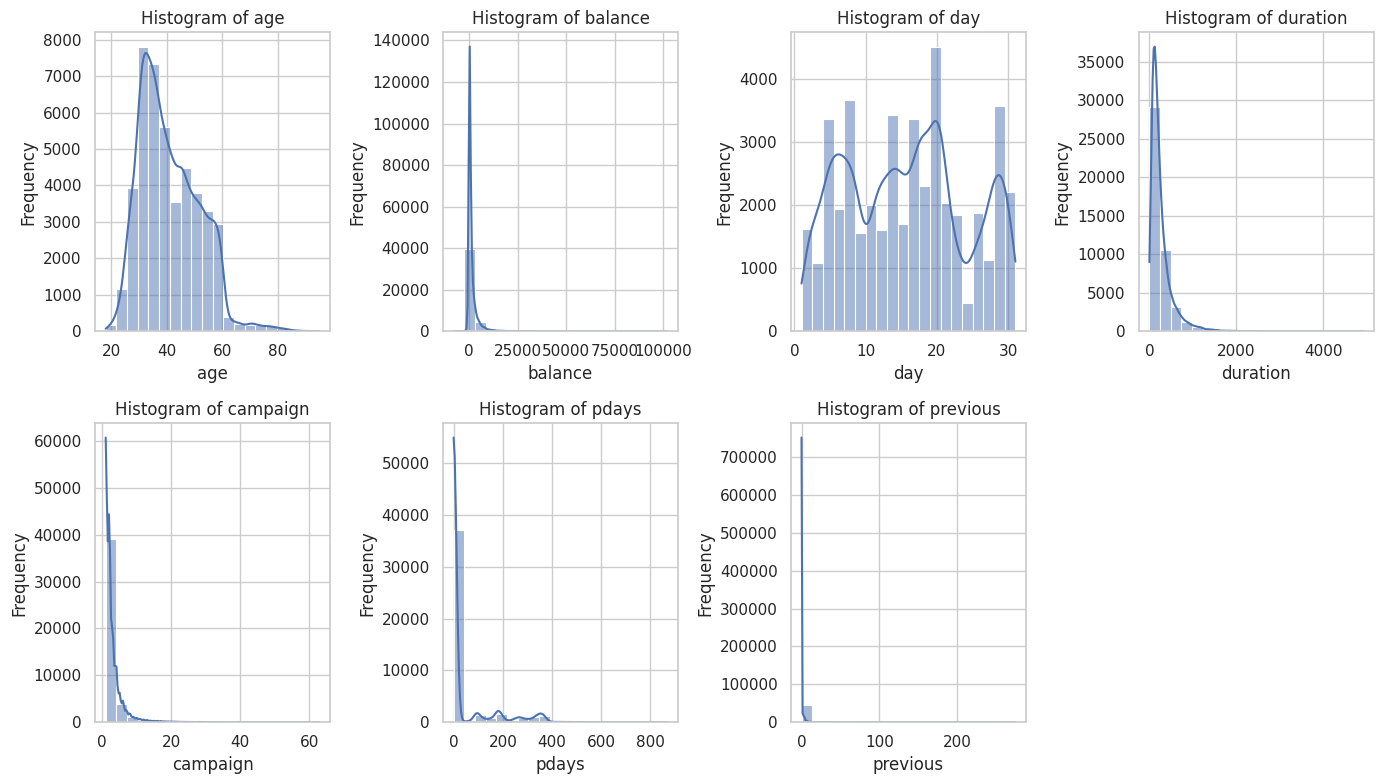

In [ ]:
plt.figure(figsize=(15, 25))
df.plot(kind="box", subplots=True, layout=(3, 3), figsize=(15, 25))
plt.show()

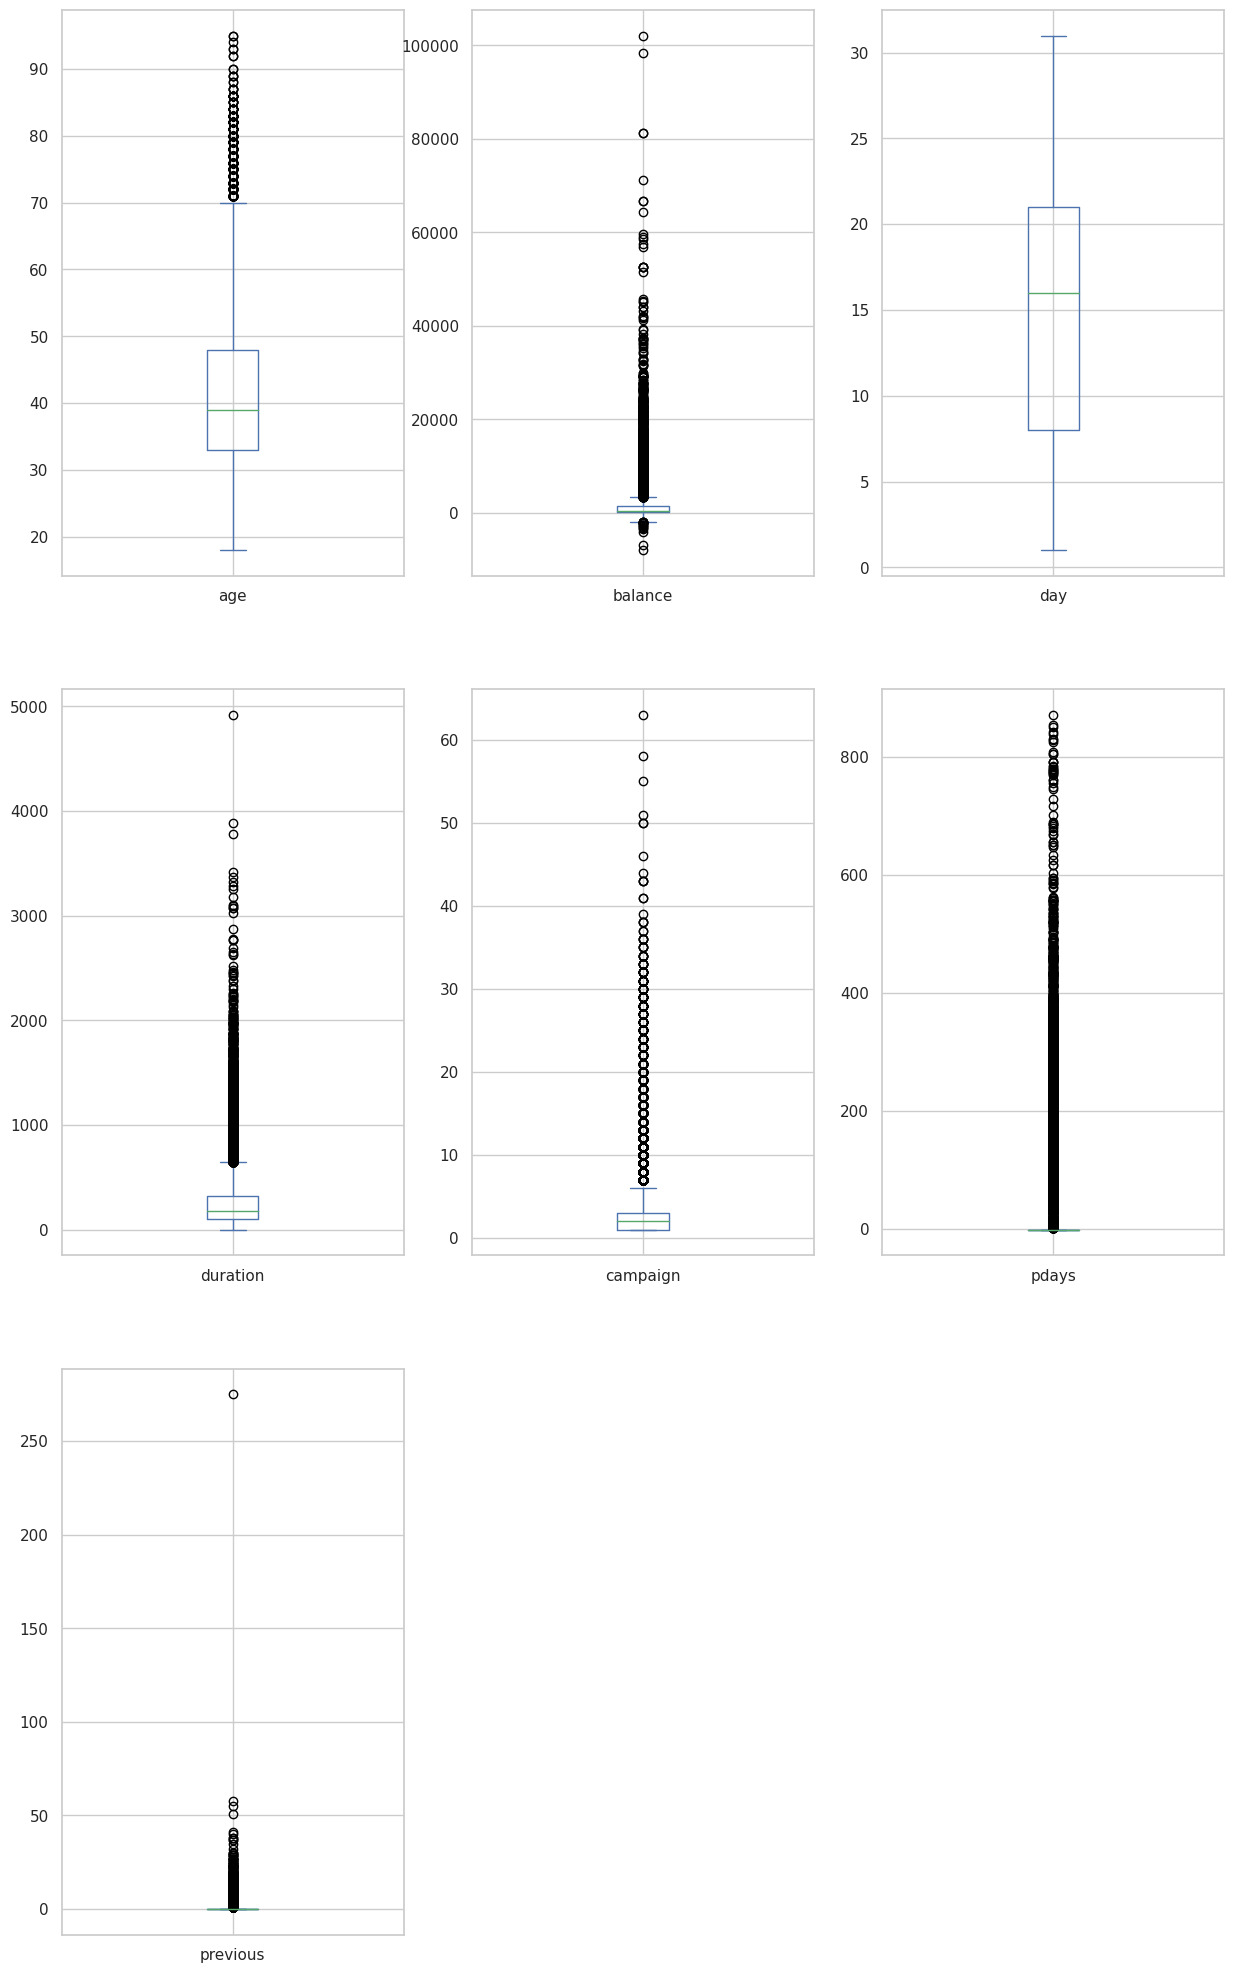

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(1 ,2 ,1)
sns.countplot(data =df ,x ='y')
plt.xticks(rotation=45)
plt.title('y Count')

plt.subplot(1 ,2 ,2)
profile_counts = df['y'].value_counts()
plt.pie(profile_counts, labels = profile_counts.index, autopct='%1.1f%%')
plt.title('y Percentage')
plt.tight_layout()
plt.show()

print(df['y'].value_counts()) # No:39922(88.3%) ,Yes:5289(11.7%)

得圖表和輸出內容得知,No:39922(88.3%) ,Yes:5289(11.7%)

# Processing Data
刪除特定欄位,做異常值處理

In [ ]:
delete_columns = ['poutcome']
df = df.drop(delete_columns, axis=1)

df = df.drop(4)

In [ ]:
numerical_columns = df.select_dtypes(include='number').columns

for column in numerical_columns:
  means = df[column].mean()
  stds = df[column].std()

  lower_bound =  means - 3 * stds
  upper_bound =  means + 3 * stds

  df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [ ]:
# Numerical statistics
df.describe()

In [ ]:
df # 45211 rows × 17 columns ---> 40339 rows × 16 columns

# Feature Engineering
將特徵和標籤做特徵工程轉換

In [ ]:
# 標籤y做LabelEncoder
lb_encoder = LabelEncoder()
df['y'] = lb_encoder.fit_transform(df['y'])
# Original values for column 'y': ['no' 'yes']
# Encoded values for column 'y': [0 1]

# 類別特徵欄位做OrdinalEncoder
cat_columns = df.select_dtypes(include='object').columns
or_encoder = OrdinalEncoder()
df[cat_columns] = or_encoder.fit_transform(df[cat_columns])

In [ ]:
df

# Hetmap
做熱力圖,顯示欄位間的相關性，並將絕對值化後的相關性列出

In [ ]:
corr = df.corr()
plt.figure(figsize=(14, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

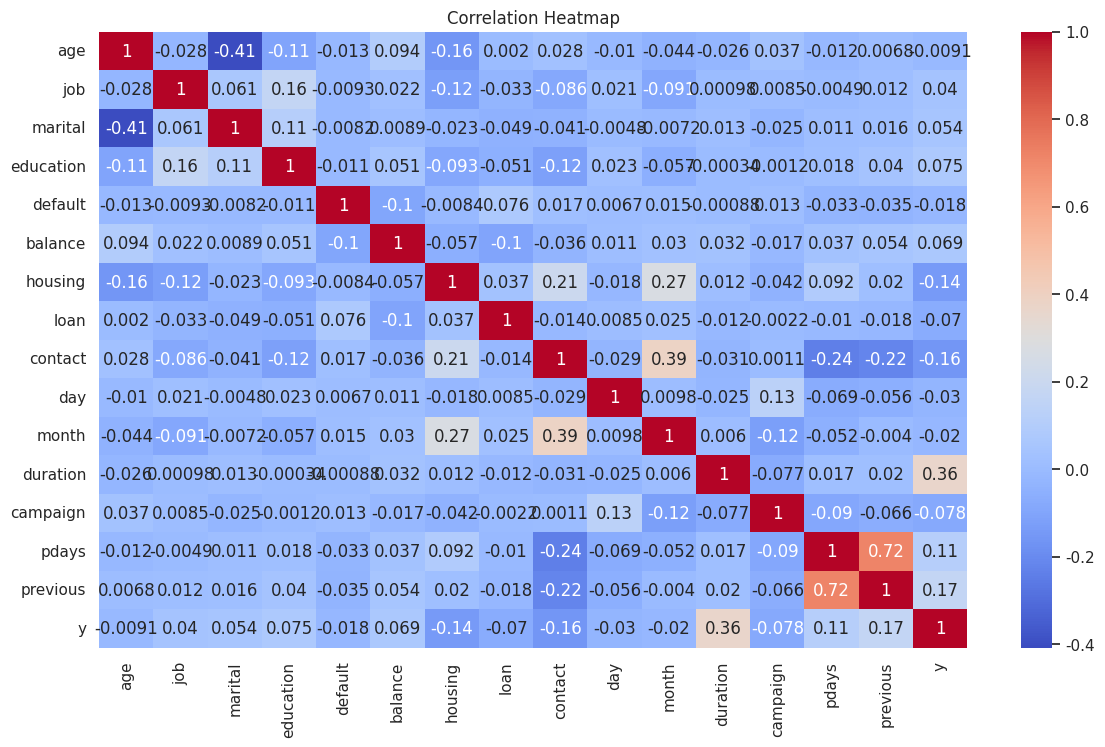

In [ ]:
correlation_matrix = df.corr().abs()
top_correlations = correlation_matrix['y'].sort_values(ascending=False).head(10)
print(top_correlations)

# Train Test Split
資料分割，將資料集拆分為訓練集和測試集

In [ ]:
X = df.drop(columns=['y'])
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', X_train.shape)
print('y_test:', X_test.shape)
print('='*30)
# 查看全部資料的類別比例
print(pd.Series(y).value_counts(normalize=True))
# 查看訓練集標籤的分佈
print(pd.Series(y_train).value_counts(normalize=True))
# 查看測試集的標籤分佈
print(pd.Series(y_test).value_counts(normalize=True))

In [ ]:
from collections import Counter

print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 25392, 1: 2845})

Testing target statistics: Counter({0: 10881, 1: 1221})

# SMOTE
SMOTE處理資料不平衡

In [ ]:
smote = SMOTE(random_state=42)
X_resample ,y_resample = smote.fit_resample(X_train, y_train)

In [ ]:
X_resample

In [ ]:
y_resample

In [ ]:
resampled_data = pd.concat([X_resample, pd.Series(y_resample, name='y')], axis=1)

resampled_data # 50794 rows × 16 columns

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(1 ,2 ,1)
sns.countplot(data =resampled_data ,x ='y')
plt.xticks(rotation=45)
plt.title('y Count')

plt.subplot(1 ,2 ,2)
profile_counts = resampled_data['y'].value_counts()
plt.pie(profile_counts, labels = profile_counts.index, autopct='%1.1f%%')
plt.title('y Percentage')
plt.tight_layout()
plt.show()

print(resampled_data['y'].value_counts()) # No:25397(50%) ,Yes:25397(50%)

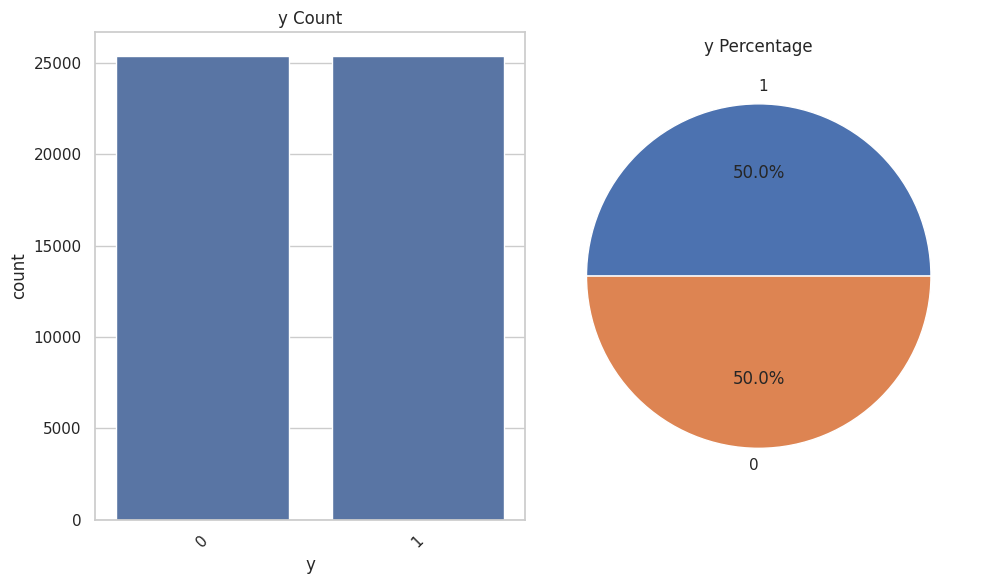

In [ ]:
X_resample = resampled_data.drop('y' ,axis =1)
y_resample = resampled_data['y']

X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size=0.3, random_state=42)

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', X_train.shape)
print('y_test:', X_test.shape)
print('='*30)
# 查看訓練集標籤的分佈
print(pd.Series(y_train).value_counts(normalize=True))
# 查看測試集的標籤分佈
print(pd.Series(y_test).value_counts(normalize=True))

In [ ]:
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({1: 17781, 0: 17767})

Testing target statistics: Counter({0: 7625, 1: 7611})

# Feature_Importances

找出重要特徵

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100 ,random_state=42)

rf_model.fit(X_train, y_train)

In [ ]:
importances = rf_model.feature_importances_

feature_scores = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores

In [ ]:
plt.figure(figsize=(10, 6))
feature_scores.plot(kind='bar', color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

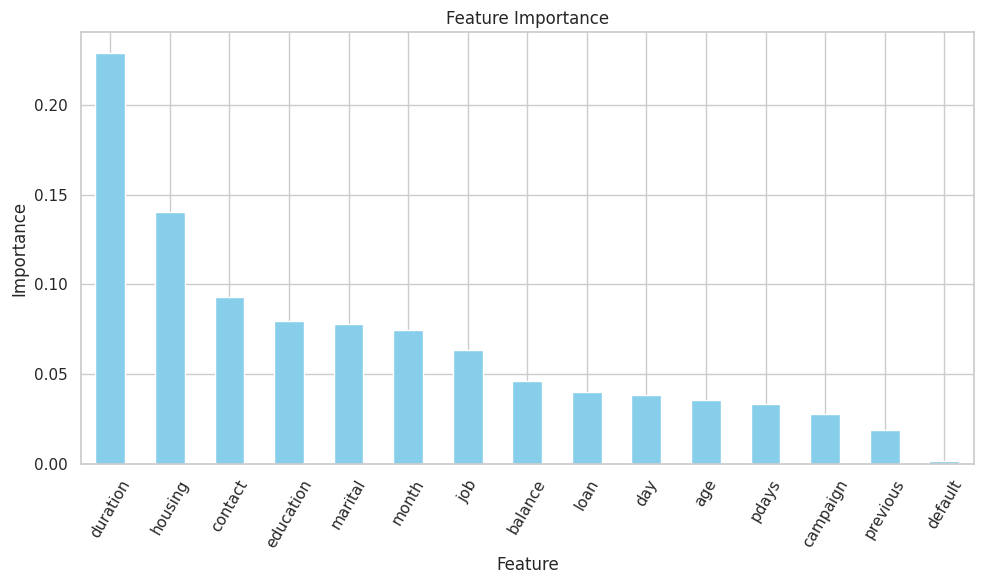

圖表得知特徵重要性前七高依序為

1.   duration : 0.29
2.   housing : 0.14
3.   contact : 0.09
4.   education : 0.08
5.   marital : 0.07
6.   month : 0.75
7.   job : 0.06

以前七高的特徵來做模型的輸入特徵


In [ ]:
selected_features = ['duration' ,'housing' ,'contact' ,'education' ,'marital' ,'month' ,'job']
X_resample = resampled_data[selected_features]
y_resample = resampled_data['y']

X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size=0.3, random_state=42)

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', X_train.shape)
print('y_test:', X_test.shape)
print('='*30)
# 查看訓練集標籤的分佈
print(pd.Series(y_train).value_counts(normalize=True))
# 查看測試集的標籤分佈
print(pd.Series(y_test).value_counts(normalize=True))

# Model
簡單的套用模型，因此不做模型訓練來尋找超參數

In [ ]:
svm_model = SVC(random_state=42)
svm_model.fit(X_train ,y_train)

lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)

# 交叉驗證

In [ ]:
svm_cv_scores = cross_val_score(svm_model, X_train, y_train, cv=5, scoring='accuracy')
svm_mean_cv_score = svm_cv_scores.mean()

print("Support Vector Machine 交叉驗證平均分數：" ,svm_mean_cv_score)

Support Vector Machine 交叉驗證平均分數： 0.7144424482030761

In [ ]:
lr_cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='accuracy')
lr_mean_cv_score = lr_cv_scores.mean()

print("Logistic Regression 交叉驗證平均分數：" ,lr_mean_cv_score)

Logistic Regression 交叉驗證平均分數： 0.7843197911405265

In [ ]:
def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    return cm, accuracy, precision, recall, f1 ,auc

In [ ]:
svm_cm_list = []
svm_accuracy_list = []
svm_precision_list = []
svm_recall_list = []
svm_f1_list = []
svm_auc_list = []

for i in range(5):
    start = int(len(X_train) * i / 5)
    end = int(len(X_train) * (i + 1) / 5)
    X_val_fold = X_train[start:end]
    y_val_fold = y_train[start:end]

    svm_y_pred = cross_val_predict(svm_model, X_train, y_train, cv=5)
    svm_cm, svm_accuracy, svm_precision, svm_recall, svm_f1, svm_auc = calculate_metrics(y_train, svm_y_pred)

    svm_cm_list.append(svm_cm)
    svm_accuracy_list.append(svm_accuracy)
    svm_precision_list.append(svm_precision)
    svm_recall_list.append(svm_recall)
    svm_f1_list.append(svm_f1)
    svm_auc_list.append(svm_auc)

    print(f"\nFold {i+1} - Confusion Matrix:")
    print(svm_cm)
    print(f"Accuracy: {svm_accuracy}, Precision: {svm_precision}, Recall: {svm_recall}, F1: {svm_f1}, AUC: {svm_auc}")

svm_mean_accuracy = sum(svm_accuracy_list) / len(svm_accuracy_list)
svm_mean_precision = sum(svm_precision_list) / len(svm_precision_list)
svm_mean_recall = sum(svm_recall_list) / len(svm_recall_list)
svm_mean_f1 = sum(svm_f1_list) / len(svm_f1_list)
svm_mean_auc = sum(svm_auc_list) / len(svm_auc_list)

print("\nSVM 交叉驗證平均accuracy：", svm_mean_accuracy)
print("SVM 交叉驗證平均precision：", svm_mean_precision)
print("SVM 交叉驗證平均recall：", svm_mean_recall)
print("SVM 交叉驗證平均f1：", svm_mean_f1)
print("SVM 交叉驗證平均AUC：", svm_mean_auc)

In [ ]:
lr_cm_list = []
lr_accuracy_list = []
lr_precision_list = []
lr_recall_list = []
lr_f1_list = []
lr_auc_list = []

for i in range(5):
    start = int(len(X_train) * i / 5)
    end = int(len(X_train) * (i + 1) / 5)
    X_val_fold = X_train[start:end]
    y_val_fold = y_train[start:end]

    lr_y_pred = cross_val_predict(lr_model, X_train, y_train, cv=5)
    lr_cm, lr_accuracy, lr_precision, lr_recall, lr_f1, lr_auc = calculate_metrics(y_train, lr_y_pred)

    lr_cm_list.append(lr_cm)
    lr_accuracy_list.append(lr_accuracy)
    lr_precision_list.append(lr_precision)
    lr_recall_list.append(lr_recall)
    lr_f1_list.append(lr_f1)
    lr_auc_list.append(lr_auc)

    print(f"\nFold {i+1} - Confusion Matrix:")
    print(lr_cm)
    print(f"Accuracy: {lr_accuracy}, Precision: {lr_precision}, Recall: {lr_recall}, F1: {lr_f1}, AUC: {lr_auc}")

lr_mean_accuracy = sum(lr_accuracy_list) / len(lr_accuracy_list)
lr_mean_precision = sum(lr_precision_list) / len(lr_precision_list)
lr_mean_recall = sum(lr_recall_list) / len(lr_recall_list)
lr_mean_f1 = sum(lr_f1_list) / len(lr_f1_list)
lr_mean_auc = sum(lr_auc_list) / len(lr_auc_list)

print("\nLogistic Regression 交叉驗證平均accuracy：", lr_mean_accuracy)
print("Logistic Regression 交叉驗證平均precision：", lr_mean_precision)
print("Logistic Regression 交叉驗證平均recall：", lr_mean_recall)
print("Logistic Regression 交叉驗證平均f1：", lr_mean_f1)
print("Logistic Regression 交叉驗證平均AUC：", lr_mean_auc)

Fold1至5所產出的指標結果都相同，這代表在交叉驗證的過程中，並沒有因為不同的訓練資料而有所變化。將該問題提問給ChatGPT後得到的回答為：可能是模型過於簡單，或是資料有問題，後續可嘗試其他模型，或調整模型超參數，亦或是使用其他的交叉驗證方法。

# Evaluate

# SVM模型在測試上的表現

In [ ]:
def plot_confusion_matrix(actual_val, pred_val, title=None):
    confusion_matrix = pd.crosstab(actual_val, pred_val,
                    rownames=['Actual'],
                    colnames=['Predicted'])
    plot = sns.heatmap(confusion_matrix, annot=True, fmt=',.0f')
    if title is not None:
        plot.set_title(title)
    plt.show()

def evaluate_model_performance(model, X_train, X_test, y_train, y_test):
    # 訓練集上的模型評分
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_conf_matrix = confusion_matrix(y_train, y_train_pred)
    train_classification_report = classification_report(y_train, y_train_pred)

    print("Training Set Evaluation:")
    print("Accuracy:", train_accuracy)
    print("Confusion Matrix:")
    print(train_conf_matrix)
    print("Classification Report:")
    print(train_classification_report)
    print("\n")

    # 測試集上的模型評分
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)
    test_classification_report = classification_report(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_pred)

    print("Testing Set Evaluation:")
    print("Accuracy:", test_accuracy)
    print("Confusion Matrix:")
    print(test_conf_matrix)
    print("Classification Report:")
    print(test_classification_report)
    print("AUC:")
    print(test_auc)

    plot_confusion_matrix(y_test, y_test_pred, title="Confusion Matrix")

evaluate_model_performance(svm_model, X_train, X_test, y_train, y_test)

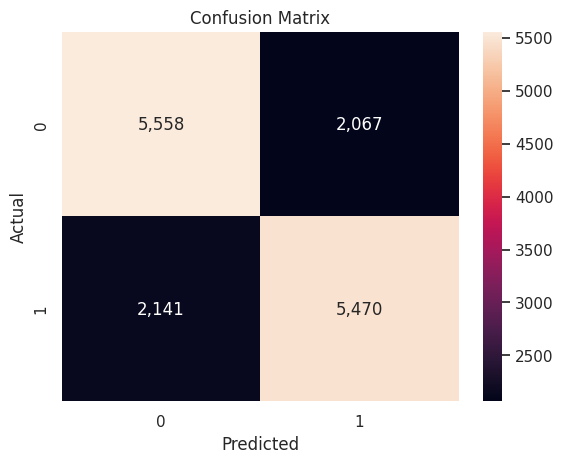

y - 顧客是否已認購定期存款

                 precision    recall    f1-score     support

           0       0.72      0.73      0.73     7625
           1       0.73      0.72      0.72     7611

    accuracy                           0.72     15236





*   測試集的整體表現Accuracy為0.72

*   有認購定期存款資料總共有7611筆，其中5470筆被成功辨識出來，2141筆沒有被辨識出來。

*   沒有認購的資料總共有7625筆，其中有2067筆資料沒認購被預測為有認購，剩下的5558筆預測皆正確。

# ROC AUC

In [ ]:
svm_y_score = svm_model.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, svm_y_score)
roc_auc = roc_auc_score(y_test, svm_y_score)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print("ROC AUC Score:", roc_auc)

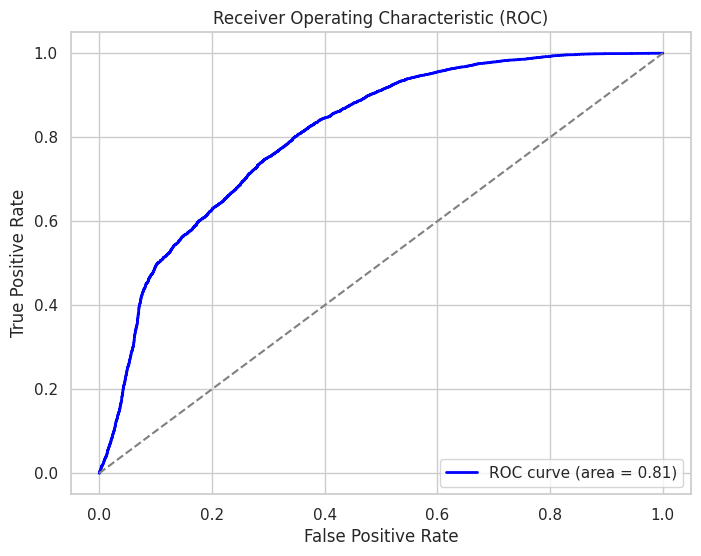

ROC AUC Score: 0.8068919316519877

# Learning Curve

In [ ]:
def plot_learning_curve(estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes, n_jobs=-1)
    # Calculate the mean and standard deviation of training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation Score")

    plt.legend(loc="best")
    plt.show()
    # Print additional information
    print("Train Sizes:", train_sizes)
    print("Train Scores Mean:", train_scores_mean)
    print("Test Scores Mean:", test_scores_mean)
plot_learning_curve(svm_model, X_train, y_train)

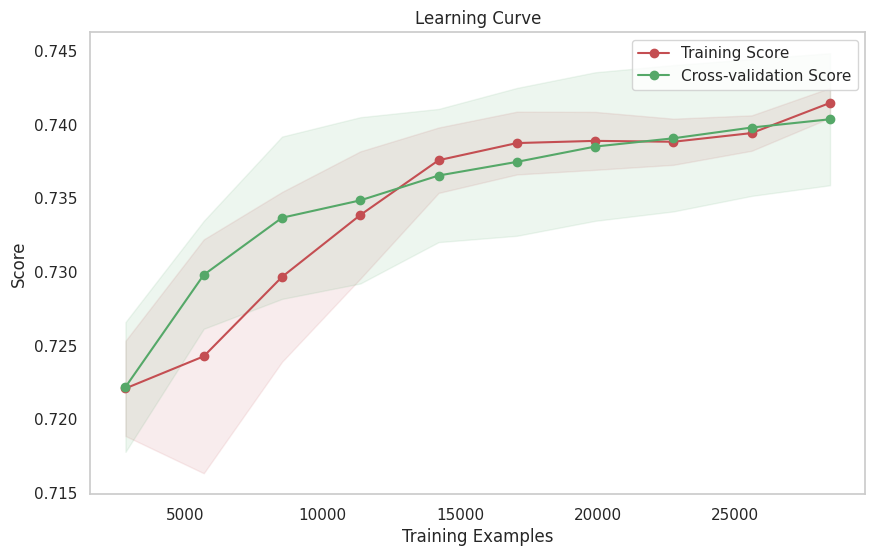


*   隨訓練樣本數量的增加，訓練分數和交叉驗證分數的差距在逐漸縮小，穩定性也隨之增加

*   隨訓練樣本數量的增加，訓練分數和交叉驗證分數趨近0.74


# LogisticRegression模型在測試上的表現

In [ ]:
evaluate_model_performance(lr_model, X_train, X_test, y_train, y_test)

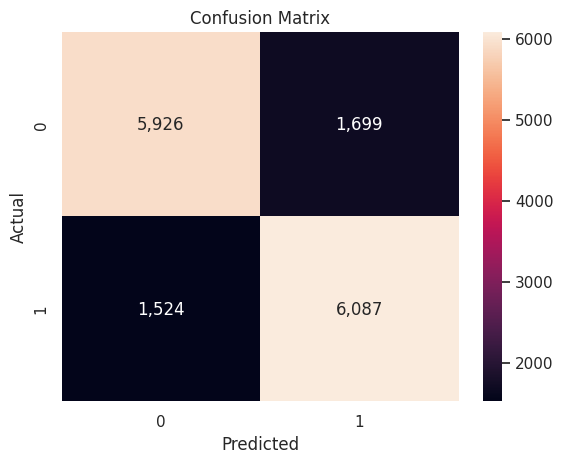

y - 顧客是否已認購定期存款

                 precision    recall    f1-score     support

           0       0.80      0.78      0.79     7625
           1       0.78      0.80      0.79     7611

    accuracy                           0.79     15236





*   測試集的整體表現Accuracy為0.79

*   有認購定期存款資料總共有7611筆，其中6087筆被成功辨識出來，1524筆沒有被辨識出來。

*   沒有認購的資料總共有7625筆，其中有1699筆資料沒認購被預測為有認購，剩下的5926筆預測皆正確。

In [ ]:
lr_y_score = lr_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, lr_y_score)
roc_auc = roc_auc_score(y_test, lr_y_score)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("ROC AUC Score:", roc_auc)

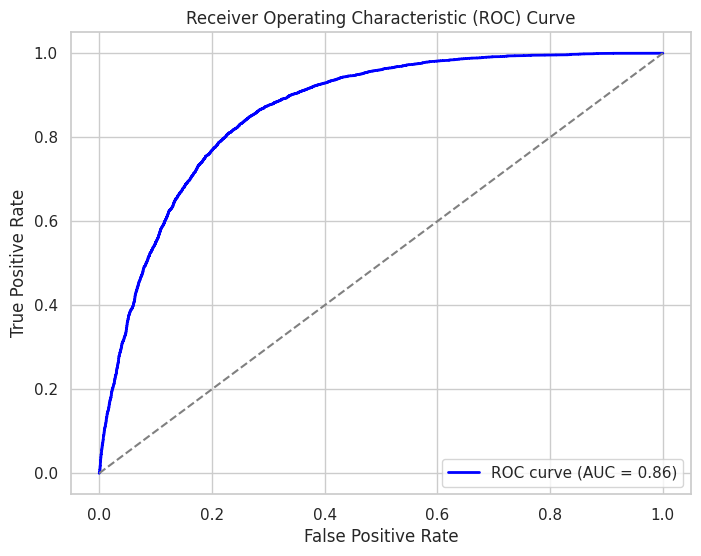

ROC AUC Score: 0.8636336708517224

In [ ]:
plot_learning_curve(lr_model, X_train, y_train)

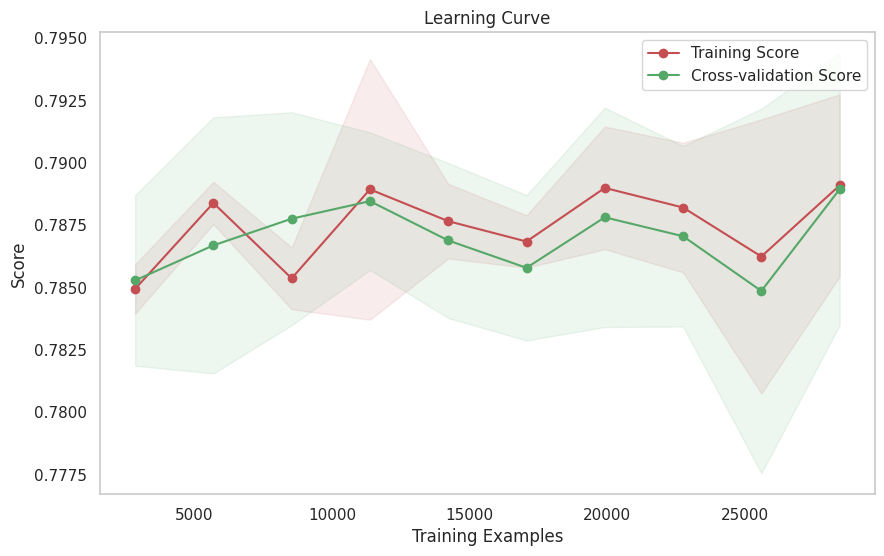


*   隨訓練樣本數量的增加，訓練分數和交叉驗證分數的差距在逐漸縮小，穩定性也隨之增加

*   隨訓練樣本數量的增加，訓練分數和交叉驗證分數趨近0.79


# Conclusion

經過異常值和處理標籤類別不平衡的問題後，將全部特徵放入Random forest使用Feature importances找出重要特徵，並使用重要特徵當作SVC及LR模型的輸入特徵，接著做交叉驗證，但在交叉驗證上卻遇到了大麻煩，之後再產出績效標以及ROC AUC。

測試的結果表現普通，兩者比較的話LogisticRegression優於SVC，之後可嘗試GridSearchCV來尋找模型超參數等，進一步提升模型的能力，或嘗試Ensemble learning algorithm( RandomForest、XGBoost、LightGBM)。



